In [2]:
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

from data_conversions import selectData, transformData
from data_conversions import floatifyData, boolifyData, quantizeData
from sampling import mkSamps, toHisto, toProbV
from sampling import createSparseBinner as createBinner
from metropolis import mutualInfo, genMetropolisSamples
from agent_based_model import createWeightedSamplesGenerator, select_subset, createWeightSer, lnLik
from agent_based_model import load_dataset

In [3]:
    subDF, acesL, boolColL, scalarColL, fixedL, passiveL, ageL = load_dataset()

    ageMin = int(min(ageL))
    ageMax = int(max(ageL))
    scalarColL.remove('AGE')
    print('scalar columns: ', scalarColL)
    ageDFD = {}
    range_d = None
    for age in range(ageMin, ageMax+1):
        ageDF = subDF[subDF.AGE==age].drop(columns=['AGE', 'FIPSST'])
        ageDFD[age], _, _, _, dct = quantizeData(ageDF, acesL, boolColL, scalarColL)
        if range_d is None:
            range_d = dct
        else:
            assert dct == range_d, 'Quantized ranges do not match?'    
            

Index(['FIPSST', 'HHID', 'FORMTYPE', 'TOTKIDS_R', 'HHLANGUAGE', 'SC_AGE_YEARS',
       'SC_SEX', 'K2Q35A_1_YEARS', 'MOMAGE', 'K6Q41R_STILL',
       ...
       'BIRTHWT', 'CBSAFP_YN', 'FWC', 'CURRINS', 'INSTYPE', 'HOUSE_GEN',
       'HHSIZE_I', 'HHSIZE_IF', 'FPL_IF', 'INSGAP'],
      dtype='object', length=422)
scalar columns:  ['BIRTHORDER', 'FPL', 'MOMAGE', 'TOTACES', 'TOTCSHCN', 'TOTKIDS']


In [4]:
# Some old groups
baseD = '/home/welling/git/synecoace/src'
uuid_tbl = """
05ef6f4e-29ec-11ea-8e5a-0f6beed8d387
73feceaa-29b3-11ea-b8c2-07fb7784e017
0da846fa-29f8-11ea-8151-8dc4f4c9d65d
bbf21c48-292d-11ea-b2bf-6f45b6cc8252
1fd98a84-29e2-11ea-904d-fd765d8a7395
be4d3b84-29b0-11ea-bc9c-bf01c2d89421
3078d6fa-29c5-11ea-83a9-19e443b2f1ca
c79600d0-29a2-11ea-81fe-ef2223dd8a1e
460b495e-29ab-11ea-9a04-61224b4e7547
e6d34352-2a03-11ea-8ff5-3b72a08fecfa
463b813e-29b8-11ea-b3b1-6b87a9b02f6d
e7a31066-2998-11ea-a01c-873589231702
"""
uuid_tbl = """
76d51fc0-2c07-11ea-b82a-e165f46b8ace
45833436-2c23-11ea-9bb5-4df7606078fb
15341b04-2c66-11ea-be3a-61109fa499c3
"""        
        


In [5]:
def load_group(baseD, uuid_tbl=None):
    if uuid_tbl is None:
        d_l = glob.glob(os.path.join(baseD, '*-*-*-*-*'))
    else:
        d_l = [os.path.join(baseD, uuid) for uuid in uuid_tbl.split()]
    meanLD = defaultdict(list)
    colL = None
    for age in range(ageMin, ageMax):
        subD = '%d_%d' % (age, age+1)
        for elt in d_l:
            fullD = os.path.join(elt, subD)
            #assert os.path.isdir(fullD)
            if not os.path.isdir(fullD):
                continue
            inner_cohort = pd.read_pickle(os.path.join(fullD, 'inner_cohort.pkl'))
            means = inner_cohort.sum()/inner_cohort.count()
            if colL is None:
                colL = [elt for elt in means.index]
                #print('columns: %s' % colL)
            if 'RECIDX' in colL:
                means = means.drop(columns='RECIDX')
                colL.remove('RECIDX')
            meanLD[subD].append(means)
    return {k:v for k, v in meanLD.items()}, colL

In [6]:
# Test explicit uuid_tbl
baseD = '/home/welling/git/synecoace/src'
uuid_tbl = """
05ef6f4e-29ec-11ea-8e5a-0f6beed8d387
73feceaa-29b3-11ea-b8c2-07fb7784e017
0da846fa-29f8-11ea-8151-8dc4f4c9d65d
bbf21c48-292d-11ea-b2bf-6f45b6cc8252
1fd98a84-29e2-11ea-904d-fd765d8a7395
be4d3b84-29b0-11ea-bc9c-bf01c2d89421
3078d6fa-29c5-11ea-83a9-19e443b2f1ca
c79600d0-29a2-11ea-81fe-ef2223dd8a1e
460b495e-29ab-11ea-9a04-61224b4e7547
e6d34352-2a03-11ea-8ff5-3b72a08fecfa
463b813e-29b8-11ea-b3b1-6b87a9b02f6d
e7a31066-2998-11ea-a01c-873589231702
"""
uuid_tbl = """
76d51fc0-2c07-11ea-b82a-e165f46b8ace
45833436-2c23-11ea-9bb5-4df7606078fb
15341b04-2c66-11ea-be3a-61109fa499c3
"""
        
testD, colL = load_group(baseD, uuid_tbl)

In [7]:
fixed_rich_white_female, colL = load_group("/home/welling/git/synecoace/src/fixed_rich_white_female")
print(colL)

['DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED', 'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE', 'BIRTHWT_L', 'BIRTHWT_VL', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH', 'PREMATURE', 'SC_CSHCN', 'SC_FEMALE', 'SC_RACE_ASIAN', 'SC_RACE_BLACK', 'SC_RACE_HISPANIC', 'SC_RACE_ISLANDS', 'SC_RACE_MIXED', 'SC_RACE_NATIVE', 'SC_RACE_OTHER', 'SC_RACE_WHITE', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'MOMAGE_LT_20', 'MOMAGE_GT_39', 'TOTACES', 'TOTCSHCN', 'TOTKIDS_minusone']


In [9]:
fixed_poor_black_male, colL2 = load_group("/home/welling/git/synecoace/src/fixed_poor_black_male")
assert colL == colL2

In [6]:
def make_summaries(meanLD, colL):
    summaryD = {}
    for col in colL:
        for age in range(ageMin, ageMax):
            subD = '%d_%d' % (age, age+1)
            df = pd.DataFrame(meanLD[subD])
            summaryD[age+1] = df.describe()
    print(summaryD.keys())
    return summaryD

In [11]:
# Some examples of the effects of culling available records
proto = pd.read_pickle('poor_black_male.pkl')
fixed_d = {elt: proto.iloc[0][elt] for elt in fixedL}
print(fixed_d)
for age in range(ageMin, ageMax+1):
    df = ageDFD[age]
    print('--------------- %d -----------' % age)
    thing = select_subset(df, fixed_d)

{'BIRTHWT_VL': 0.0, 'PREMATURE': 0.0, 'HHLANGUAGE_ENGLISH': 1.0, 'SC_FEMALE': 0.0, 'SC_RACE_NATIVE': 0.0, 'SC_RACE_ASIAN': 0.0, 'SC_RACE_ISLANDS': 0.0, 'SC_RACE_OTHER': 0.0, 'SC_RACE_MIXED': 0.0, 'SC_RACE_HISPANIC': 0.0, 'MOMAGE_LT_20': 0.0, 'MOMAGE_GT_39': 0.0}
--------------- 6 -----------
begin select_subset: 223 records, 223 unique
BIRTHWT_VL == 0.0: 220 entries, 220 unique
PREMATURE == 0.0: 188 entries, 188 unique
HHLANGUAGE_ENGLISH == 1.0: 175 entries, 175 unique
SC_FEMALE == 0.0: 77 entries, 77 unique
SC_RACE_NATIVE == 0.0: 77 entries, 77 unique
SC_RACE_ASIAN == 0.0: 72 entries, 72 unique
SC_RACE_ISLANDS == 0.0: 72 entries, 72 unique
SC_RACE_OTHER == 0.0: 71 entries, 71 unique
SC_RACE_MIXED == 0.0: 70 entries, 70 unique
SC_RACE_HISPANIC == 0.0: 65 entries, 65 unique
MOMAGE_LT_20 == 0.0: 62 entries, 62 unique
MOMAGE_GT_39 == 0.0: 55 entries, 55 unique
--------------- 7 -----------
begin select_subset: 230 records, 230 unique
BIRTHWT_VL == 0.0: 227 entries, 227 unique
PREMATURE ==

In [44]:
pop1_grp, colL = load_group("/home/welling/git/synecoace/src/population2_poor_white_male")
lbl1 = 'Caucasian at age 6'
print(colL)

['DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED', 'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE', 'BIRTHWT_L', 'BIRTHWT_VL', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH', 'PREMATURE', 'SC_CSHCN', 'SC_FEMALE', 'SC_RACE_ASIAN', 'SC_RACE_BLACK', 'SC_RACE_HISPANIC', 'SC_RACE_ISLANDS', 'SC_RACE_MIXED', 'SC_RACE_NATIVE', 'SC_RACE_OTHER', 'SC_RACE_WHITE', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'MOMAGE_LT_20', 'MOMAGE_GT_39', 'TOTACES', 'TOTCSHCN', 'TOTKIDS_minusone']


In [45]:
pop2_grp, new_colL = load_group("/home/welling/git/synecoace/src/population2_poor_black_male")
lbl2 = 'African American at age 6'
print(new_colL)
assert colL == new_colL, 'columns do not match'

['DRUGSALCOHOL', 'MENTALILL', 'PARENTDIED', 'PARENTDIVORCED', 'PARENTJAIL', 'RACISM', 'SEEPUNCH', 'VIOLENCE', 'BIRTHWT_L', 'BIRTHWT_VL', 'CLUBS', 'DENTALCARE', 'DOCTORVISIT', 'HHLANGUAGE_ENGLISH', 'HHLANGUAGE_SPANISH', 'PREMATURE', 'SC_CSHCN', 'SC_FEMALE', 'SC_RACE_ASIAN', 'SC_RACE_BLACK', 'SC_RACE_HISPANIC', 'SC_RACE_ISLANDS', 'SC_RACE_MIXED', 'SC_RACE_NATIVE', 'SC_RACE_OTHER', 'SC_RACE_WHITE', 'SPORTSTEAMS', 'VISIONCARE', 'BIRTHORDER_minusone', 'FPL', 'MOMAGE_LT_20', 'MOMAGE_GT_39', 'TOTACES', 'TOTCSHCN', 'TOTKIDS_minusone']


In [46]:
pop1_summaries = make_summaries(pop1_grp, colL)

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])


In [47]:
pop2_summaries = make_summaries(pop2_grp, colL)

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])


/home/welling/anaconda3/envs/py3Env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


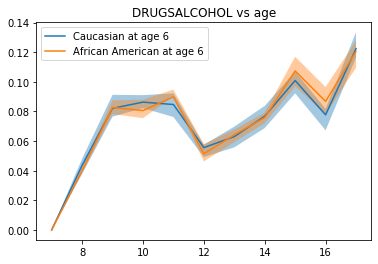

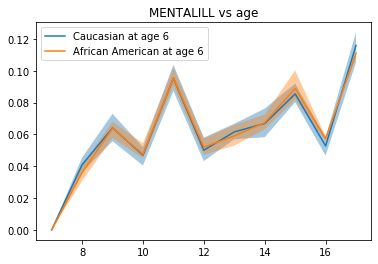

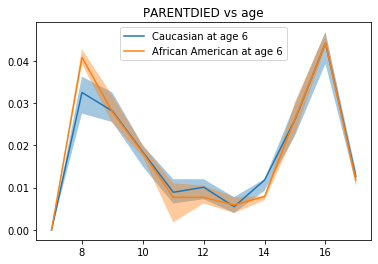

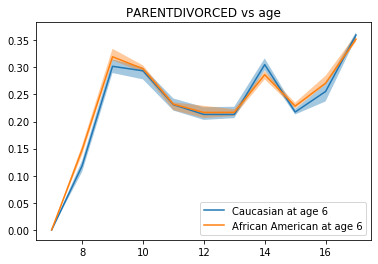

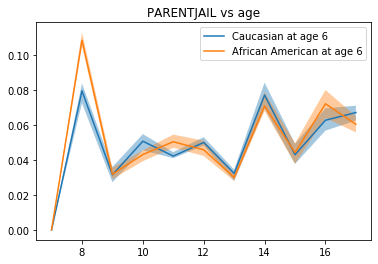

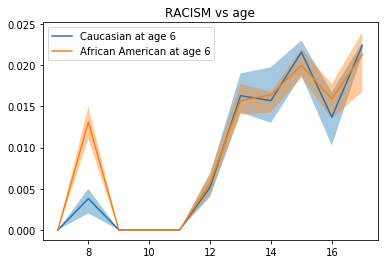

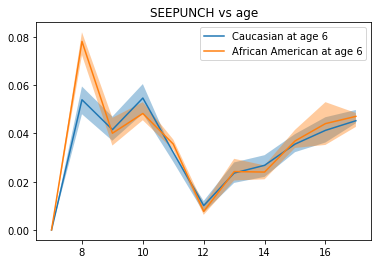

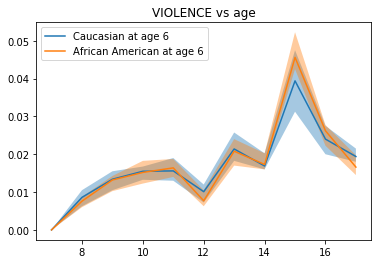

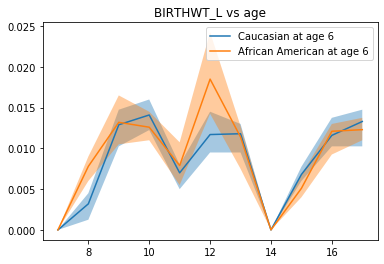

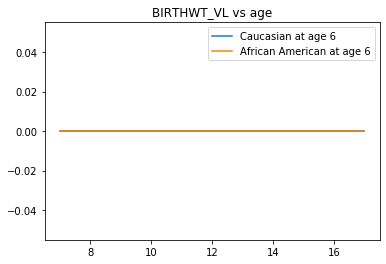

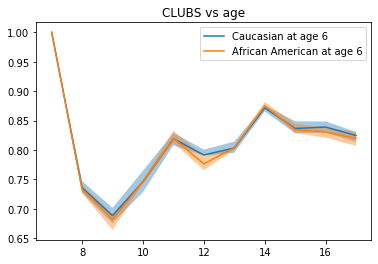

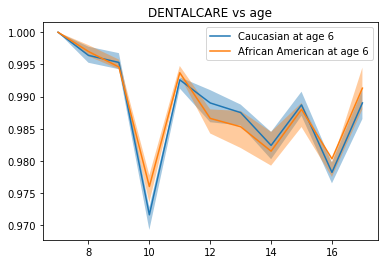

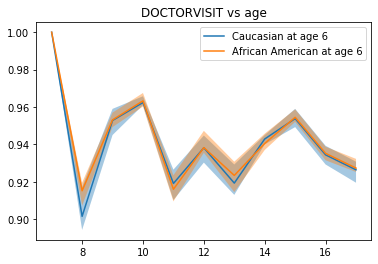

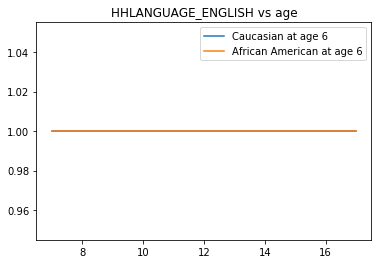

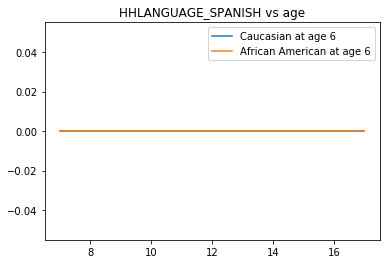

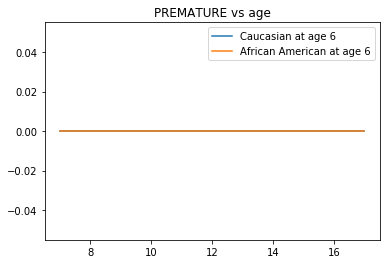

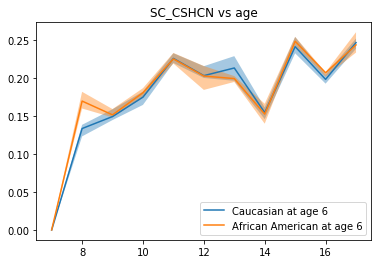

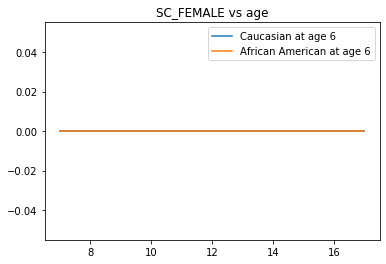

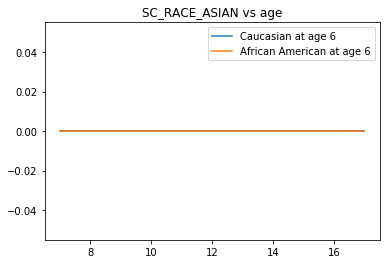

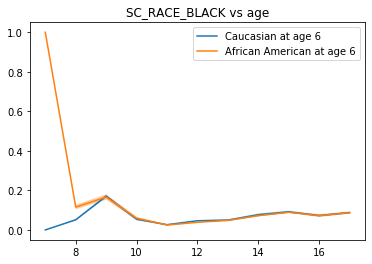

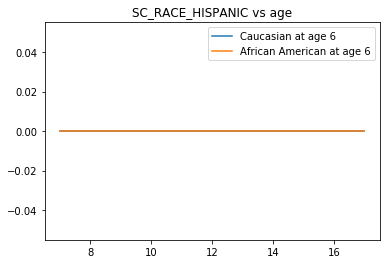

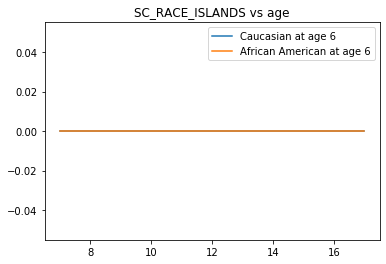

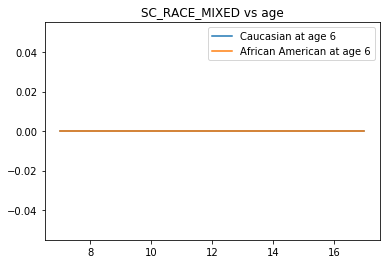

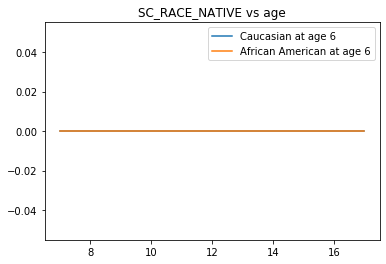

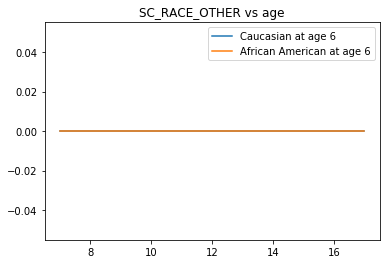

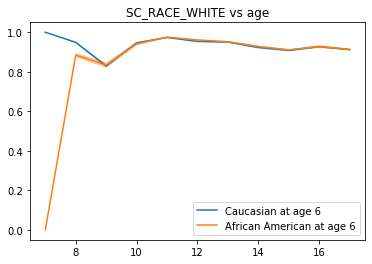

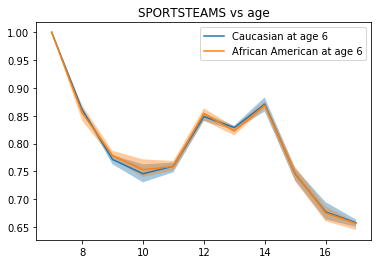

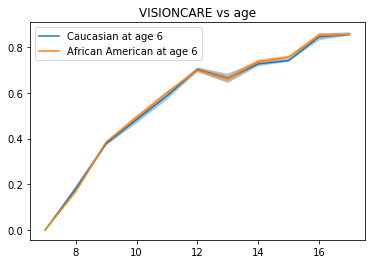

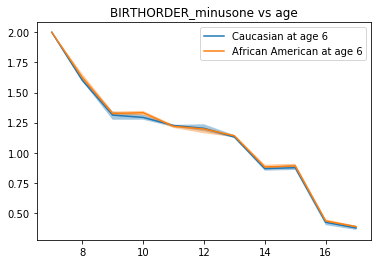

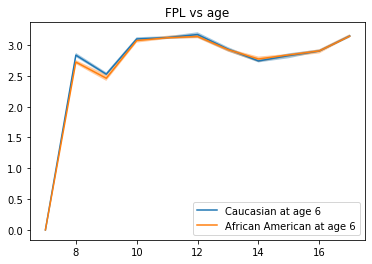

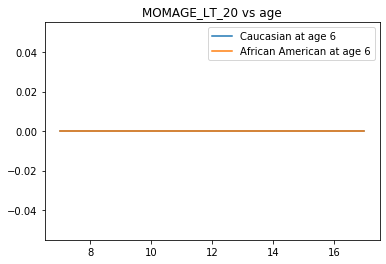

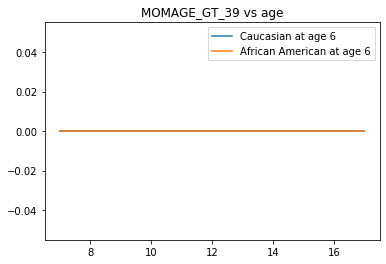

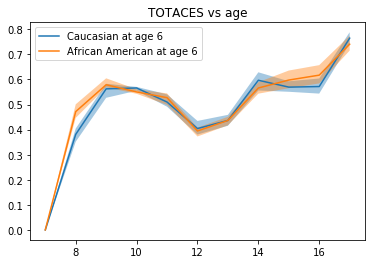

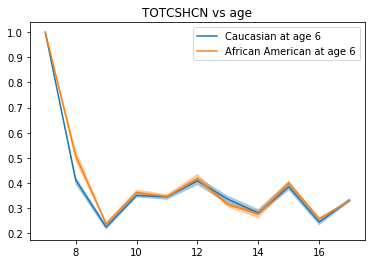

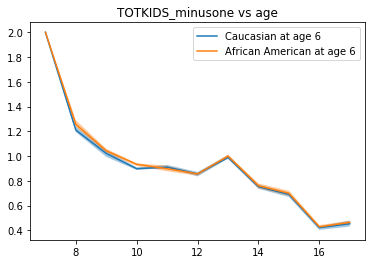

In [51]:
ageL = [elt for elt in range(ageMin+1, ageMax+1)]
for col in colL:
    fig, axes = plt.subplots(1,1)
    axes.set_title('%s vs age' % col)
    axes.plot(ageL, [pop1_summaries[age][col]['mean'] for age in ageL], label=lbl1)
    axes.fill_between(ageL,
                      [pop1_summaries[age][col]['25%'] for age in ageL],
                      [pop1_summaries[age][col]['75%'] for age in ageL],
                      alpha=0.4)
    axes.plot(ageL, [pop2_summaries[age][col]['mean'] for age in ageL], label=lbl2)
    axes.fill_between(ageL,
                      [pop2_summaries[age][col]['25%'] for age in ageL],
                      [pop2_summaries[age][col]['75%'] for age in ageL],
                      alpha=0.4)
    axes.legend()
    #plt.show()
    plt.savefig('ethnicity_variability_%s.svg' % col)